In [108]:
import fitsio
import numpy as np
import k3d
import pandas as pd
import SEdist
import pygwalker as pyg
import matplotlib.pyplot as plt
import scienceplots
import scipy.spatial
plt.style.use(['science','ieee','high-contrast'])


from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck15 as default_cosmo
import astropy.units as u

def add_cartesian_coordinates(df, cosmo=default_cosmo, redshifts=None):
    # Extract RA, Dec, and redshift from the DataFrame
    ra = df['ra'].values
    dec = df['dec'].values
    if redshifts is None:
        redshifts = df['redshift_quaia'].values 
    else:
        df['redshifts'] = redshifts

    # Calculate comoving distance using the cosmology model
    comoving_distance = cosmo.comoving_distance(redshifts)

    # Create SkyCoord object
    coords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, distance=comoving_distance)

    # Convert to Cartesian coordinates
    x = coords.cartesian.x.value
    y = coords.cartesian.y.value
    z = coords.cartesian.z.value

    # Add Cartesian coordinates to the DataFrame
    df['x'] = np.float32(x)
    df['y'] = np.float32(y)
    df['z'] = np.float32(z)

    return df


# Helper function to generate a mesh for a sphere geometry to display with k3d
def generate_sphere(radius=1.0, center=(0, 0, 0), resolution=30):
    u = np.linspace(0, 2 * np.pi, resolution)
    v = np.linspace(0, np.pi, resolution)
    u, v = np.meshgrid(u, v)

    x = center[0] + radius * np.cos(u) * np.sin(v)
    y = center[1] + radius * np.sin(u) * np.sin(v)
    z = center[2] + radius * np.cos(v)

    # Flatten arrays
    vertices = np.vstack([x.ravel(), y.ravel(), z.ravel()]).T

    # Create faces (triangular mesh)
    faces = []
    for i in range(resolution - 1):
        for j in range(resolution - 1):
            p1 = i * resolution + j
            p2 = p1 + 1
            p3 = (i + 1) * resolution + j
            p4 = p3 + 1
            faces.append([p1, p2, p3])
            faces.append([p2, p4, p3])

    faces = np.array(faces, dtype=np.uint32)

    return vertices, faces


In [2]:
# Read FITS data from the specified directory
d205 = fitsio.read('../../data/quaia/quaia_G20.5.fits')
r205 = fitsio.read('../../data/quaia/random_G20.5_10x.fits')

df = pd.DataFrame(d205.byteswap().newbyteorder())
rf = pd.DataFrame(r205.byteswap().newbyteorder())

# Add cartesian coordinates DataFrame
df = add_cartesian_coordinates(df)

# randoms do not have redshifts. Let's create them from the redshift distribution of the data. 
sez =  SEdist.SE_distribution(df["redshift_quaia"]) # create empirical empirical distribution function
newz = sez.rvs(size=len(rf['ra']))                  # samples new random variates from it
rf = add_cartesian_coordinates(rf, redshifts=newz)

In [3]:

# Convert the FITS data to a pandas DataFrame with native byte order
#pyg.walk(df)

In [4]:
# Convert the FITS data to a pandas DataFrame with native byte order
pyg.walk(rf)

Box(children=(HTML(value='\n<div id="ifr-pyg-00062e87475dc8a4GZcTm5nfOdr7iL6S" style="height: auto">\n    <hea…

In [ ]:
import k3d
from scipy.spatial import distance

# Create a plot
plot = k3d.plot()

# Calculate the distance of each point from the origin
distances = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)

# Find the radius that encompasses 99% of the points
radius_99 = np.percentile(distances, 99)

# Generate sphere vertices and faces
vertices, faces = generate_sphere(radius=radius_99, center=(0, 0, 0), resolution=30)

# Create a mesh for the sphere
sphere_mesh = k3d.mesh(vertices, faces, color=0xff0000, opacity=0.3, wireframe=True)
# Add the sphere to the plot
plot += sphere_mesh

# Label the sphere with its redshift value
label = k3d.text(
    text=f'Redshift: {np.percentile(df["redshift_quaia"], 99):.2f}',
    position=[radius_99, 0, 0],
    color=0xff0000,
    size=1.0
)

# Add the label to the plot
plot += label

# Create a 3D scatter plot
colors = np.float32(df['redshift_quaia'].values)
#points = k3d.points(positions=np.vstack([df['x'],df['y'],df['z']]).T, point_size=0.1, color_map=k3d.colormaps.matplotlib_color_maps.Jet, attribute=colors)

# Add points to the plot
#plot += points

# Display the plot
#plot.display()

/Users/tabel/pyEnvs/k3dEnv/lib/python3.11/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


In [6]:
dt = scipy.spatial.cKDTree(np.vstack([df['x'],df['y'],df['z']]).T) # tree of data
rt = scipy.spatial.cKDTree(np.vstack([rf['x'],rf['y'],rf['z']]).T) # tree of randoms

### Find the distances to the k-th nearest neighbors
We measure from the randoms to the k-th data point and record the distances

In [74]:
#ks = [1, 2, 4, 8, 9, 16, 25, 128]
#ks = [1, 2, 8, 9, 64, 65, 512, 513, 4096, 4097] # which neighbours 
ks = [1, 2, 8, 9, 64, 65, 512, 513] # which neighbours 
dis, disi =  dt.query(np.vstack([rf['x'],rf['y'],rf['z']]).T, k=ks, workers=-1) # query data tree at randoms

### Given the distances now measure the volume
By measuring how many randoms are in the spheres of the size to the k-th nearest data point we get a volume estimate exploiting the randoms property of being uniformly distributed. 

In [97]:
indices = np.random.choice(len(rf['x']), 3_000_000, replace=False)  # downsample [is faster]
#indices = np.arange(len(rf['x']))
rl = np.zeros((len(indices),len(ks)))
for c, k in enumerate(ks):
    rl[:,c] = rt.query_ball_point( (np.vstack([rf['x'],rf['y'],rf['z']]).T)[indices,:], dis[indices,c], return_length=True, workers=-1)
    cdfs[k] = SEdist.SE_distribution(rl[:,c], compress="log", Ninterpolants=50000)
#cdfs[k] = SEdist.SE_distribution(rl)
    

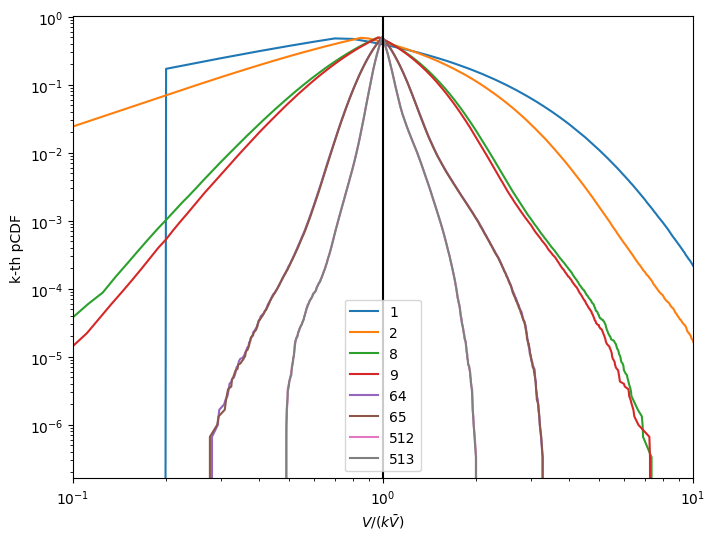

In [ ]:
fig = plt.figure(figsize=(8,6))

for c, k in enumerate(ks):
    plt.loglog(cdfs[k].x()/k/10, cdfs[k].pcdf(cdfs[k].x()),label=str(k))
plt.axvline(1,color='black')
plt.xlabel(r'$V/(k\bar{V})$')
plt.ylabel(r'k-th pCDF')
plt.xlim([1e-1,1e1])
plt.legend();

Equation 8 of [Banerjee & Abel 2022](https://doi.org/10.1093/mnras/staa3604) :
$$
P_{k \mid V}=\mathrm{CDF}_{k \mathrm{NN}}(r)-\mathrm{CDF}_{(k+1) \mathrm{NN}}(r) \quad \forall k \geq 1
$$


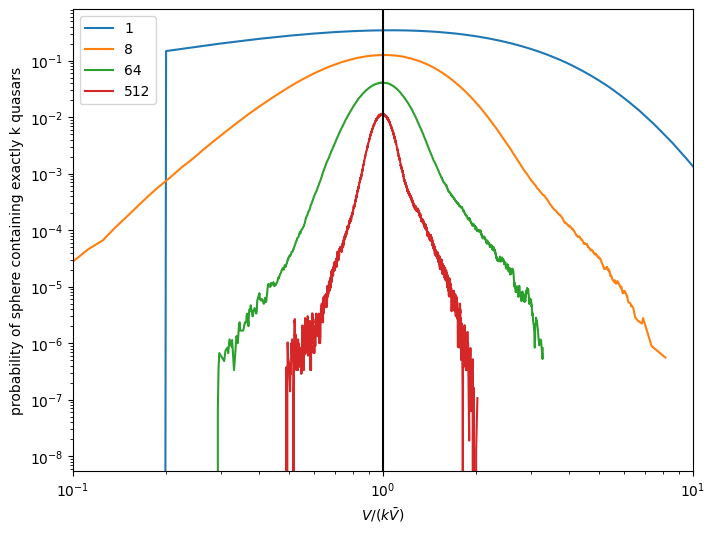

In [91]:
# P_k
fig = plt.figure(figsize=(8,6))
for c, k in enumerate(ks[::2]):
    plt.loglog(cdfs[k].x()/k/10, cdfs[k].cdf(cdfs[k].x())-cdfs[k+1].cdf(cdfs[k].x()),label=str(k))
plt.axvline(1,color='black')
plt.xlabel(r'$V/(k\bar{V})$')
plt.ylabel(r'probability of sphere containing exactly k quasars')
plt.xlim([1e-1,1e1])
plt.legend();

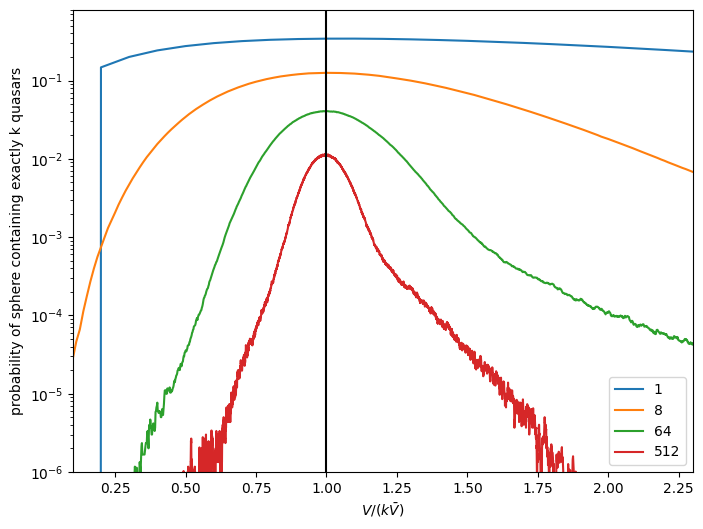

In [95]:
# P_k
fig = plt.figure(figsize=(8,6))
for c, k in enumerate(ks[::2]):
    plt.semilogy(cdfs[k].x()/k/10, cdfs[k].cdf(cdfs[k].x())-cdfs[k+1].cdf(cdfs[k].x()),label=str(k))
plt.axvline(1,color='black')
plt.xlabel(r'$V/(k\bar{V})$')
plt.ylabel(r'probability of sphere containing exactly k quasars')
plt.xlim([1e-1,2.3])
plt.ylim([1e-6,0.8])
plt.legend();

In [113]:
vols = 4*np.pi/3 * dis[indices,:]**3
vcdfs = {}
for c, k in enumerate(ks):
    vcdfs[k] = SEdist.SE_distribution(vols[:,c], compress="log", Ninterpolants=50000)
    
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))


<Figure size 4800x3600 with 0 Axes>

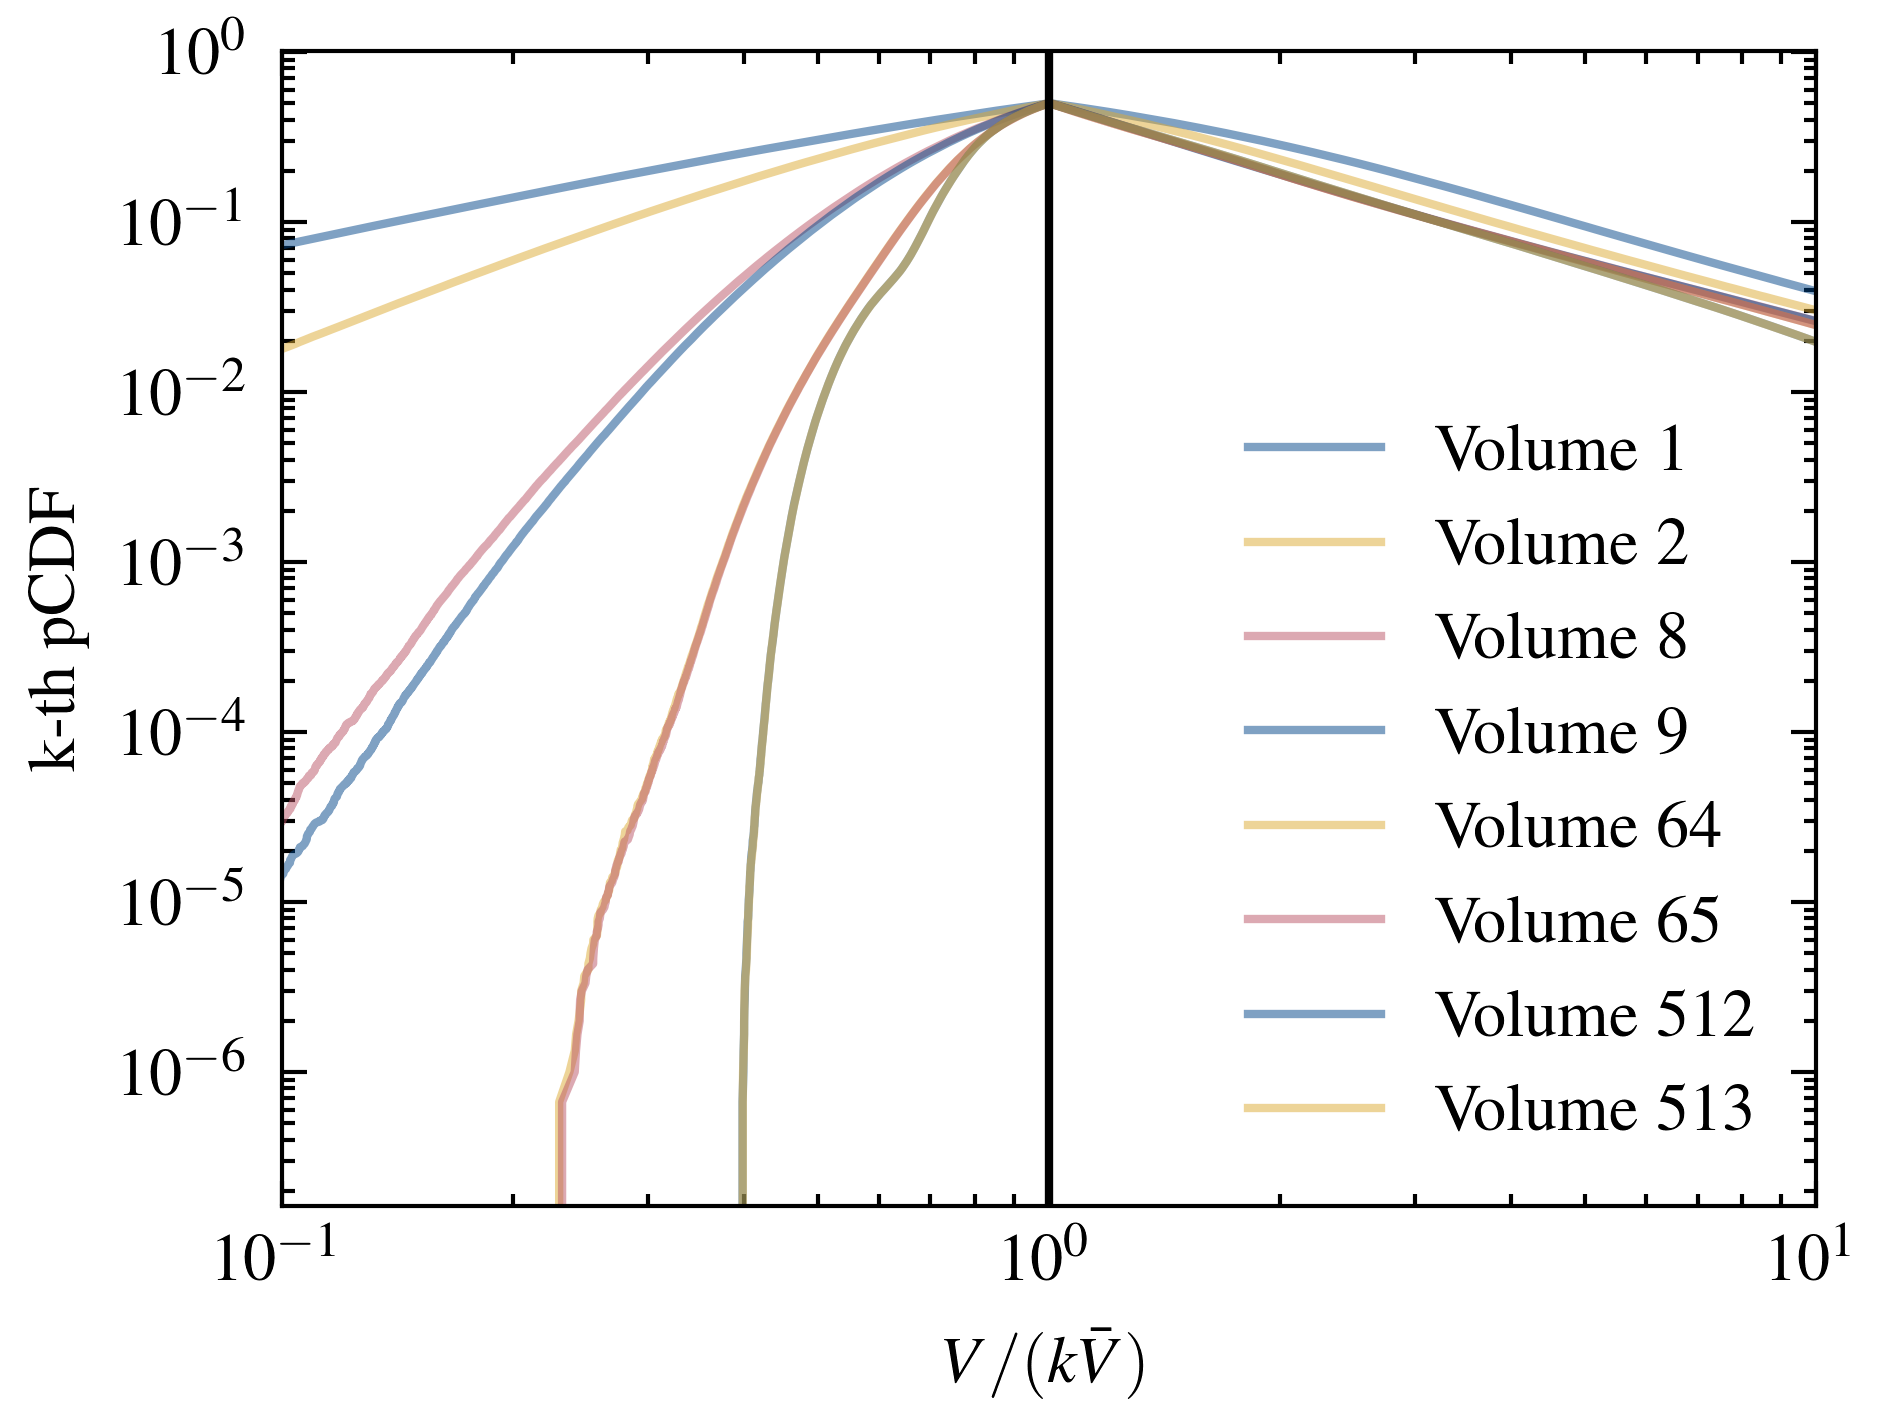

In [ ]:
for c, k in enumerate(ks):
    color = plt.gca()._get_lines.get_next_color()
    plt.loglog(vcdfs[k].x()/vcdfs[k].median(), vcdfs[k].pcdf(vcdfs[k].x()), label=f'Volume {k}', color=color,alpha=0.5,lw=2)
#    plt.loglog(cdfs[k].x()/k/10, cdfs[k].pcdf(cdfs[k].x()),label=str(k), color=color)
plt.axvline(1,color='black')
plt.xlabel(r'$V/(k\bar{V})$')
plt.ylabel(r'k-th pCDF')
plt.xlim([1e-1,1e1])
plt.legend();

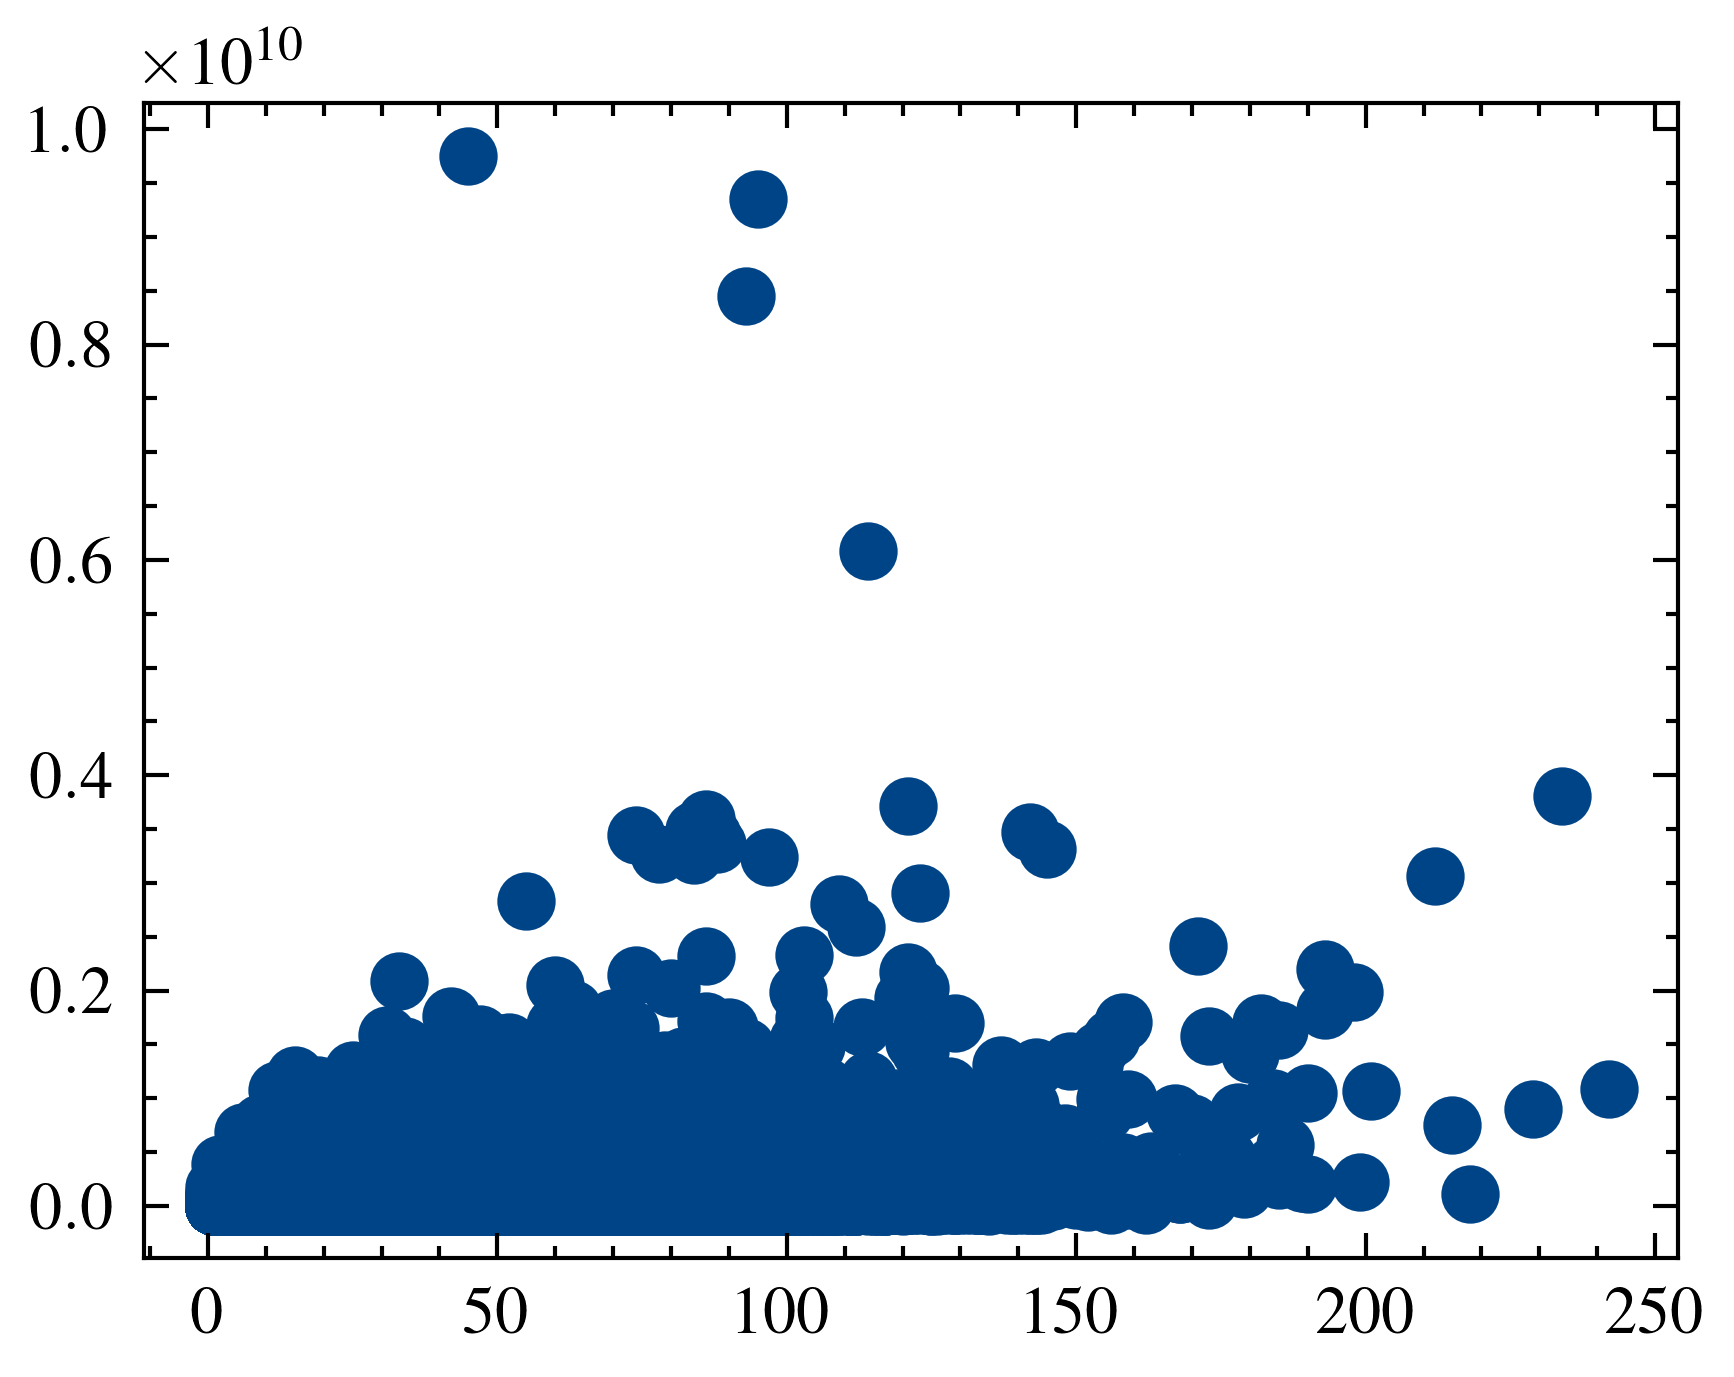

In [116]:
plt.scatter(rl[:,0], vols[:,0])

vcdfs[1].mean()

In [112]:
(rl[:,0].shape, vols[:,0].shape)

((3000000,), (12955802,))

In [ ]:
def plot_2d_cdf(xx, yy):
    def gridECDF2D(xx, yy, xgi, ygi):
        # Ensure bin edges fully cover data range and are strictly increasing
        # Extend the first and last bin with -inf and +inf
        x_bins = np.concatenate(([ -np.inf ], xgi, [ np.inf ]))
        y_bins = np.concatenate(([ -np.inf ], ygi, [ np.inf ]))
        # Compute 2D histogram
        h2d, xe, ye = np.histogram2d(xx, yy, bins=(x_bins, y_bins))
        # Compute 2D ECDF
        cdf = np.cumsum(np.cumsum(h2d, axis=0), axis=1) / len(xx)
        return cdf[0:-1,0:-1].T

    se1 = SEdist.SE_distribution(xx, compress="log")
    se2 = SEdist.SE_distribution(yy, compress="log")

    Nh = 200
    xgi = np.linspace(se1.ppf(1e-8), se1.ppf(1-1e-8), Nh)
    ygi = np.linspace(se2.ppf(1e-8), se2.ppf(1-1e-8), Nh)

    ells = np.linspace(0, 1, 11)
    ells[0] = 1e-4
    ells[10] = 1-1e-4

    # JOINT CDF, PEAKED CDF AND PDF 
    from mpl_toolkits.axes_grid1 import ImageGrid
    fig = plt.figure(figsize=(13, 6))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.45, cbar_mode="each", cbar_location="right", cbar_pad=0.1)

    # CDF
    cdf2 = gridECDF2D(xx, yy, xgi, ygi)
    cc = grid[0].imshow(cdf2, origin='lower', extent=[xgi.min(), xgi.max(), ygi.min(), ygi.max()], alpha=0.7)

    grid[0].contour(cdf2, origin='lower', extent=[xgi.min(), xgi.max(), ygi.min(), ygi.max()], colors="black", alpha=.5, levels=ells)
    uncdf2 = np.outer(se1.cdf(xgi), se2.cdf(ygi)).T  # if it were uncorrelated then it is product of marginals

    grid[0].contour(uncdf2, origin='lower', extent=[xgi.min(), xgi.max(), ygi.min(), ygi.max()], linewidths=1, colors="red", alpha=.5, levels=ells)

    grid[0].set_title("CDF")
    grid[0].set_xlabel("Field 1")
    grid[0].set_ylabel("Field 2")
    grid.cbar_axes[0].colorbar(cc)

    # PCDF
    pcdf2 = np.minimum(cdf2, 1-cdf2)  # peaked CDF
    cc = grid[1].imshow(pcdf2, origin='lower', extent=[xgi.min(), xgi.max(), ygi.min(), ygi.max()], interpolation='spline36', alpha=0.7)
    grid[1].contour(cdf2, origin='lower', extent=[xgi.min(), xgi.max(), ygi.min(), ygi.max()], colors="black", alpha=.6, levels=ells)
    grid[1].set_title("PCDF")
    unpcdf2 = np.minimum(uncdf2, 1-uncdf2)  # peaked CDF

    grid[1].contour(unpcdf2, origin='lower', extent=[xgi.min(), xgi.max(), ygi.min(), ygi.max()], linewidths=1, colors="red", alpha=.5, levels=ells)

    # Create 'proxy' line artists (these won't actually be plotted)
    import matplotlib.lines as mlines
    black_line = mlines.Line2D([], [], color='black', label='actual')
    red_line = mlines.Line2D([], [], color='red', label='uncorrelated')

    grid[1].legend(handles=[black_line, red_line])

    grid[1].set_xlabel("Field 1")
    grid.cbar_axes[1].colorbar(cc)

    # PDF
    grad2 = np.gradient(cdf2, xgi, axis=0)
    der2 = np.gradient(grad2.reshape(Nh, Nh), ygi, axis=1)
    ga2 = der2
    ccc = grid[2].imshow(ga2, origin='lower', extent=[xgi.min(), xgi.max(), ygi.min(), ygi.max()], alpha=0.7)

    grid[2].set_title(r"$PDF=\partial^2 CDF/\partial x \partial y$")
    grid[2].set_xlabel("Field 1")
    grid.cbar_axes[2].colorbar(ccc)
#    for ax in grid:
    #        ax.set_aspect('equal', adjustable='box', anchor='C')
    for ax in grid:
        ax.set_aspect(1)  # Force square aspect ratio
        ax.set_xlim(xgi.min(), xgi.max())  # Maintain correct x-axis limits
        ax.set_ylim(ygi.min(), ygi.max())  # Maintain correct y-axis limits
        plt.show()

    return cdf2

# Example usage:
# cdf2 = plot_2d_cdf(xy[0], xy[1], xgi, ygi)


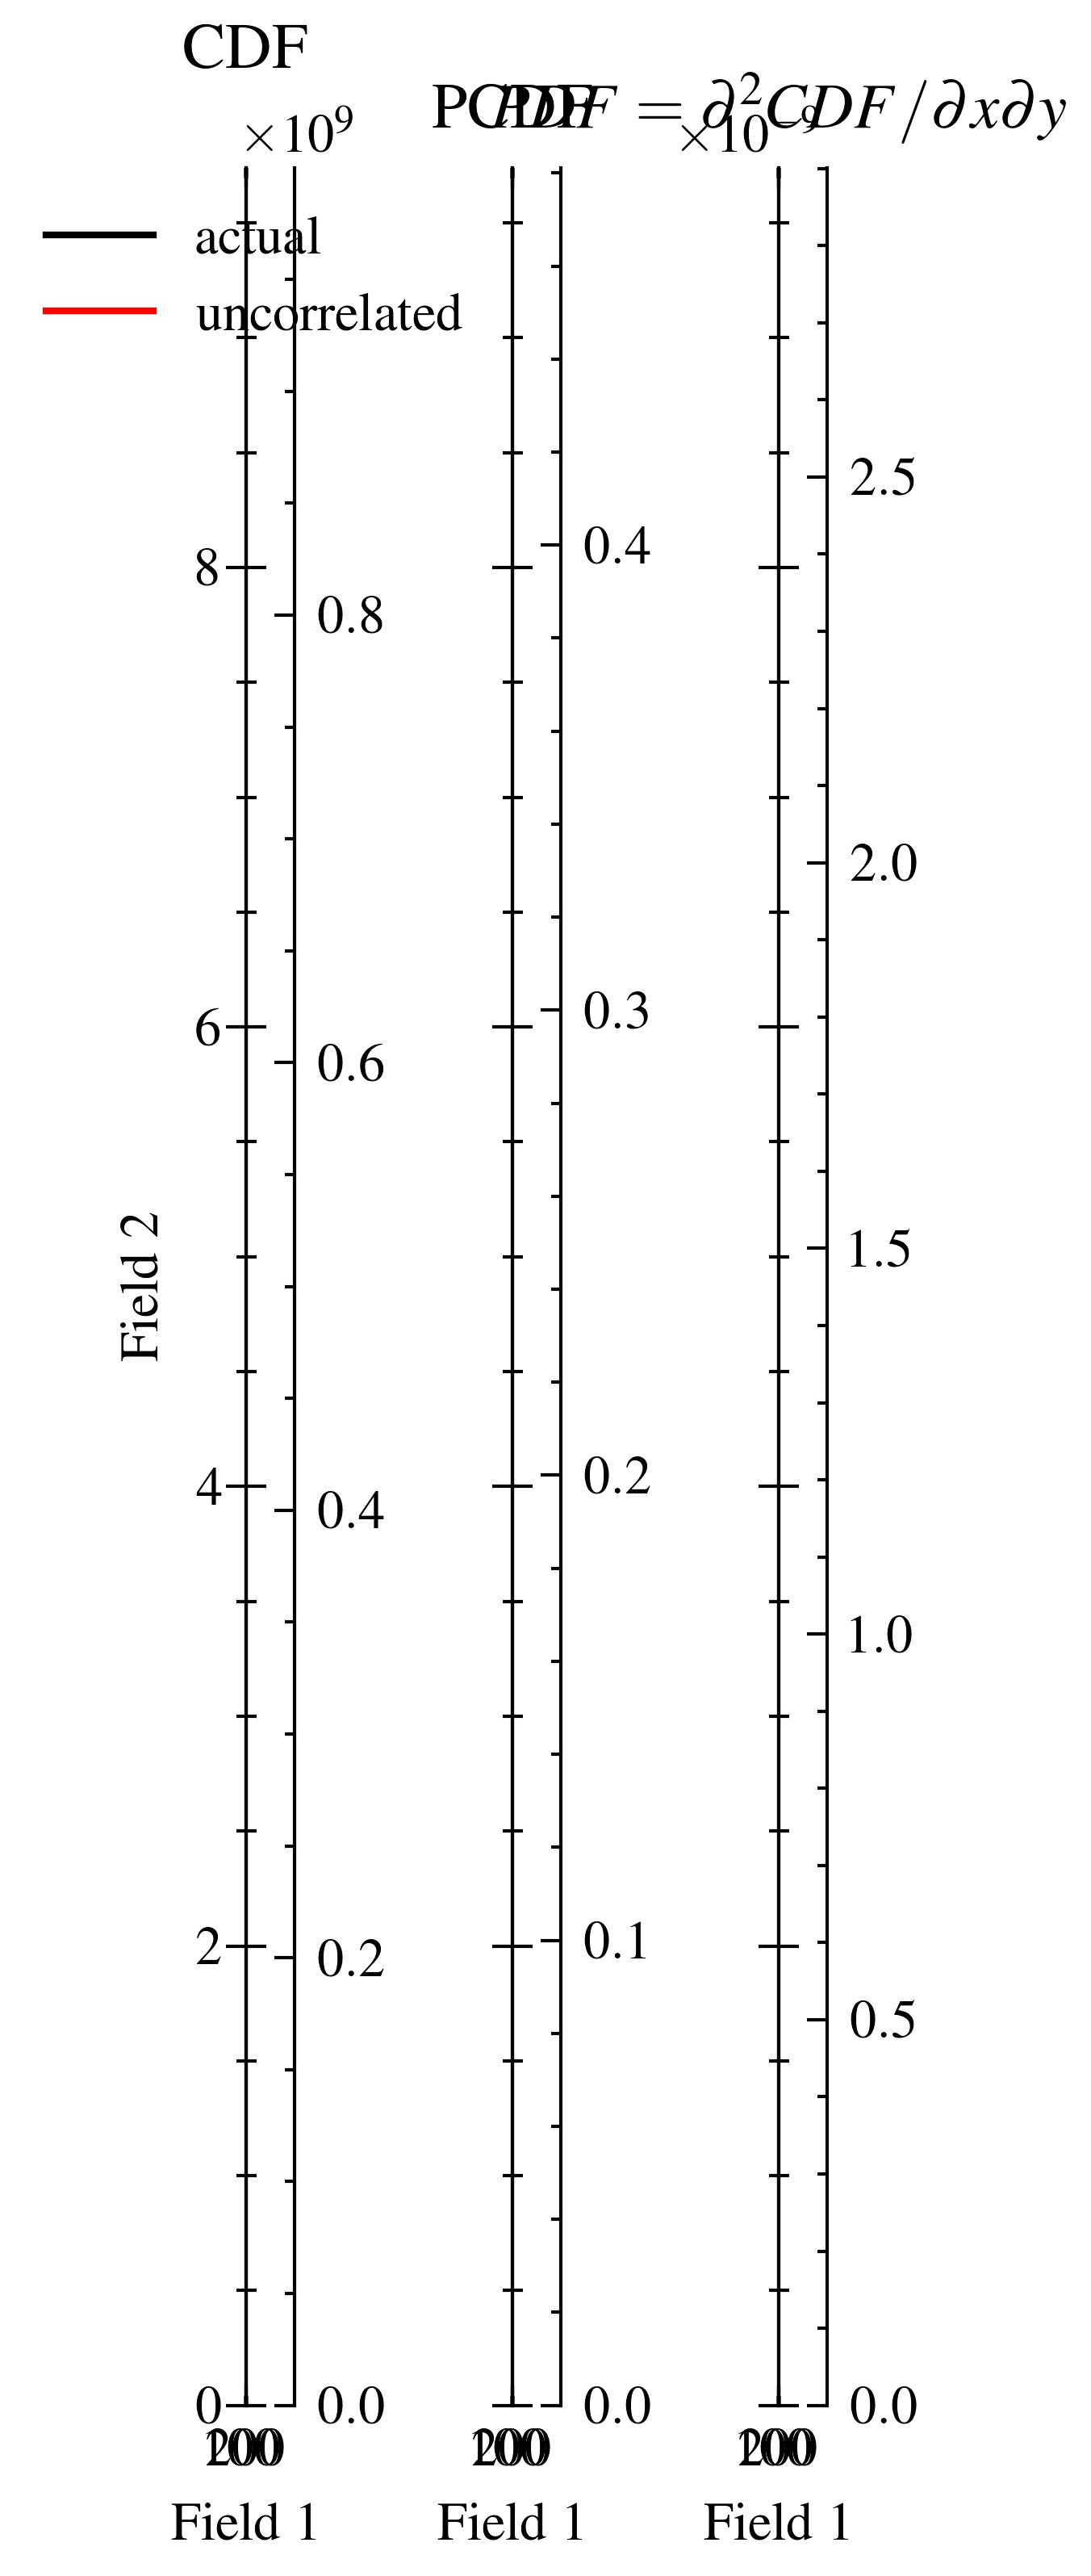

In [118]:
cdf2 = plot_2d_cdf(rl[:,0], vols[:,0])